# Problem Explanation

Problem: Daniel is a young professional, who is currently considering purchasing either a HDB unit or private property (e.g., apartment/condo) for a 3-year investment. 

Objective: develop a predictive model for candidate site selection
- Help Daniel understand SG property market 
- maximize his return on investment, i.e., % gain in 3 years

# Section 1. Exploratory Data Analysis

In [165]:
import pandas as pd
import statistics
import numpy as np
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
#Read in data for hdb
dfhdb=pd.read_csv("hdb ver2.csv")

#Read in data for condo
dfcondo=pd.read_csv("Jan10-Aug20_resale.csv")

# a. Tidying up for Data 

#### Tidying up condo data

In [167]:
"""Since Daniel is considering between resale HDB and condo, we remove property
transacted above $10 million as it is unlikely for someone with that budget to look at property that range for investment"""
dfcondo=dfcondo[dfcondo['Transacted Price']<10000000]

#Selecting resale condominium
dfcondo=dfcondo[dfcondo['No. of Units']==1]
dfcondo=dfcondo[dfcondo['Property Type']=='Condominium']
dfcondo=dfcondo[dfcondo['Type of Sale'] =='Resale']

#Convert to datetime
dfcondo['Sale Date']=pd.to_datetime(dfcondo['Sale Date']).dt.to_period('M')

#Cleaning up tenure column
dfcondo = dfcondo[dfcondo['Tenure'] !='N.A.']
dfcondo['Tenure'] = dfcondo['Tenure'].str.split(' F').str[0]
dfcondo['Tenure'] = dfcondo['Tenure'].str.replace('Years Leasehold','Yrs')

#Removing condos that sell with uncommon tenures. Only keep those with common tenures (99 years, 999 years, freehold)
dfcondo = dfcondo[dfcondo['Tenure']!='101 Yrs']
dfcondo = dfcondo[dfcondo['Tenure']!='103 Yrs']
dfcondo = dfcondo[dfcondo['Tenure']!='946 Yrs']
dfcondo = dfcondo[dfcondo['Tenure']!='956 Yrs']

#Removing condo with floors unknown and basement units
dfcondo = dfcondo[dfcondo['floor'] > 0]

#Setting floors into range to allign with HDB data 
dfcondo = dfcondo.replace({'floor':{1:2,  2:2,  3:2,  4:5,  5:5,  6:5,  7:8,  8:8,  9:8, 10:11, 11:11, 12:11,
       13:14, 14:14, 15:14, 16:17, 17:17, 18:17, 19:20, 20:20, 21:20, 22:23, 23:23, 24:23, 25:26,
       26:26, 27:26, 28:29, 29:29, 30:29, 31:32, 32:32, 33:32, 34:35, 35:35, 36:35, 37:38, 38:38,
       39:38, 40:41, 41:41, 42:41, 43:44, 44:44, 45:44, 46:47, 47:47, 48:47, 49:50, 50:50, 51:50,
       52:53, 54:53, 55:56, 56:56, 57:56, 58:59, 59:59, 60:59, 61:62, 62:62, 65:65}})

#Getting the age of the house at point of sale
dfcondo['Completion Date'] = dfcondo['Completion Date'].astype(int)
dfcondo['Sale_year']=dfcondo['Sale Date'].dt.year
dfcondo['age_sale'] =dfcondo['Sale_year'] - dfcondo['Completion Date']

#### Tidying up HDB data

In [168]:
"""Since Daniel is considering between resale dfhdb and condo, we remove property
transacted above $10 million as it is unlikely for someone with that budget to look at property that range for investment"""
dfhdb=dfhdb[dfhdb['resale_price']<10000000]

# Year & Month
dfhdb['Sale Date']=pd.to_datetime(dfhdb['month']).dt.to_period('M')
dfhdb['month'] = pd.to_datetime(dfhdb['month'])
dfhdb.rename(columns={'month':'month_year'}, inplace=True) 
dfhdb['year'] = dfhdb['month_year'].dt.year
dfhdb['month']= dfhdb['month_year'].dt.month

# Age
dfhdb['age'] = dfhdb['year'] - dfhdb['lease_commence_date']

# Category vars
categoryVariableList = ["town","flat_type","flat_model"]
for var in categoryVariableList:
    dfhdb[var] = dfhdb[var].astype("category")

# Floor data for dfhdb is in range so we convert and fill in the mdedian value
dfhdb['storey_range']= dfhdb['storey_range'].astype(str)
dfhdb['floor_min'] = dfhdb['storey_range'].str[:2].astype(int)
dfhdb['floor_max'] = dfhdb['storey_range'].str[6:].astype(int)
col = dfhdb.loc[: , "floor_min":"floor_max"]
dfhdb['floor'] = col.median(axis=1).astype(int)

# Price per area
dfhdb['price_per']=dfhdb['resale_price']/dfhdb['floor_area_sqm']

# Drop useless cols
dropList = ['remaining_lease','lease_commence_date','storey_range','floor_min','floor_max']
for var in dropList:
    dfhdb = dfhdb.drop(var, axis=1)

# b. Exporatory Data Analysis

#### Plotting out the prices over last 10 years

In [169]:
#Condo
avg_price_condo=[dfcondo.groupby('Sale Date')['Transacted Price'].agg(np.mean)]
avg_price_condo=pd.DataFrame(avg_price_condo)
avg_price_condo=avg_price_condo.T
avg_price_condo.index=avg_price_condo.index.to_series().astype(str)
avg_price_condo.reset_index(level=0, inplace=True)

#HDB
avg_price_hdb=[dfhdb.groupby('Sale Date')['resale_price'].agg(np.mean)]
avg_price_hdb=pd.DataFrame(avg_price_hdb)
avg_price_hdb=avg_price_hdb.T
avg_price_hdb.index=avg_price_hdb.index.to_series().astype(str)
avg_price_hdb.reset_index(level=0, inplace=True)

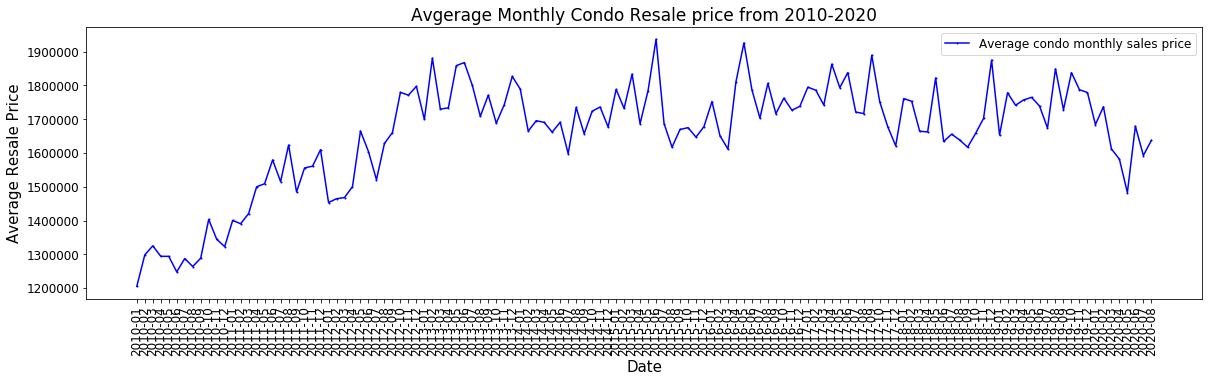

In [170]:
#Plotting price over time of Condo transactions
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot_date(avg_price_condo['Sale Date'], avg_price_condo['Transacted Price'],linestyle = 'solid', color = 'blue', markersize = 1, label = 'Average condo monthly sales price')
ax1.ticklabel_format(axis = 'y', style= 'sci',scilimits =(0,7))
plt.xticks(rotation=90)
ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Average Resale Price',fontsize=15)
ax1.set_title('Avgerage Monthly Condo Resale price from 2010-2020',fontsize=17)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.show()  

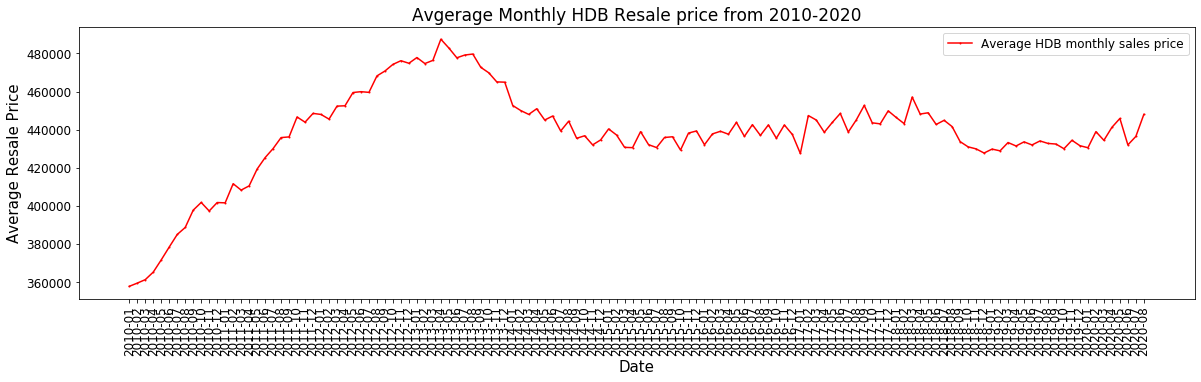

In [171]:
#Plotting price over time of EC and Condo transactions
fig, ax1 = plt.subplots(figsize=(20, 5))
#ax1.plot_date(avg_price_condo['Sale Date'], avg_price_condo['Transacted Price'],linestyle = 'solid', color = 'blue', markersize = 1, label = 'Average ondo monthly sales price')
ax1.plot_date(avg_price_hdb['Sale Date'], avg_price_hdb['resale_price'],linestyle = 'solid', color = 'red', markersize = 1, label = 'Average HDB monthly sales price')
ax1.ticklabel_format(axis = 'y', style= 'sci',scilimits =(0,7))
plt.xticks(rotation=90)
ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Average Resale Price',fontsize=15)
ax1.set_title('Avgerage Monthly HDB Resale price from 2010-2020',fontsize=17)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.show()  

#### Correlation Matrix

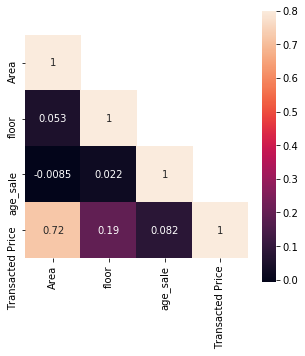

In [172]:
#Condo
corrMatt = dfcondo[["Area","floor","age_sale","Transacted Price"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

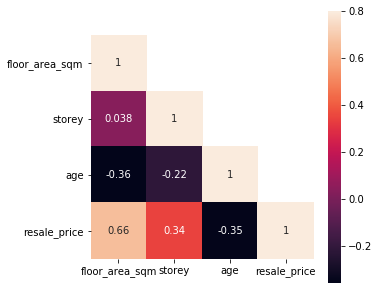

In [173]:
#HDB
corrMatt = dfhdb[["floor_area_sqm","storey","age","resale_price"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

#### Plotting of Resale price vs Location

In [174]:
def catPlot2(var):
    f, ax = plt.subplots(figsize=(12, 5))
    fig = sns.boxplot(x=var, y="box_price_change", data=yearly_price)
    plt.xticks(rotation=45)
    plt.show()

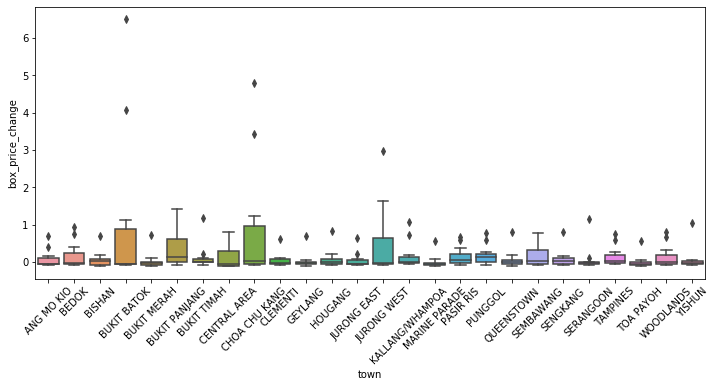

In [175]:
from scipy import stats
categoryVariableList = ["town"]

for var in categoryVariableList:
    yearly_price = dfhdb.groupby([var,'year'])['price_per'].median().reset_index(name='yearly_price')
    yearly_price['price_change']=yearly_price.yearly_price.diff(3).shift(-3).dropna()
    yearly_price['price_pct_change']=yearly_price['price_change']/yearly_price['yearly_price']
    yearly_price['box_price_change'], lmbda = stats.boxcox(yearly_price.price_pct_change+1)
    catPlot2(var)

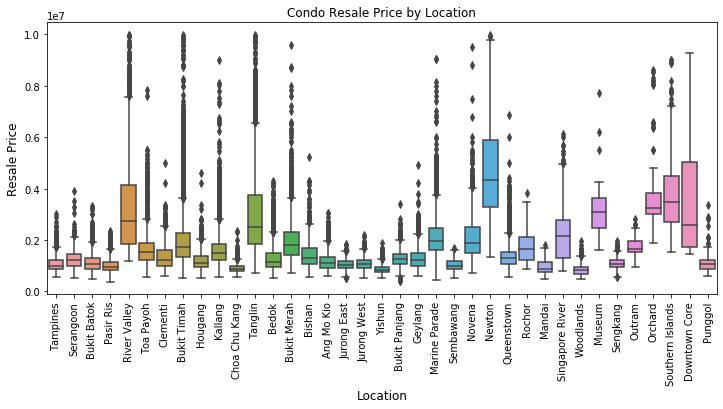

In [176]:
# Condo
def catPlot(var):
    f, ax = plt.subplots(figsize=(12, 5))
    fig = sns.boxplot(x=var, y="Transacted Price", data=dfcondo)
    fig.set_title('Condo Resale Price by Location',fontsize=12)
    fig.set_xlabel('Location',fontsize=12)
    fig.set_ylabel('Resale Price',fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

catPlot('Planning Area')

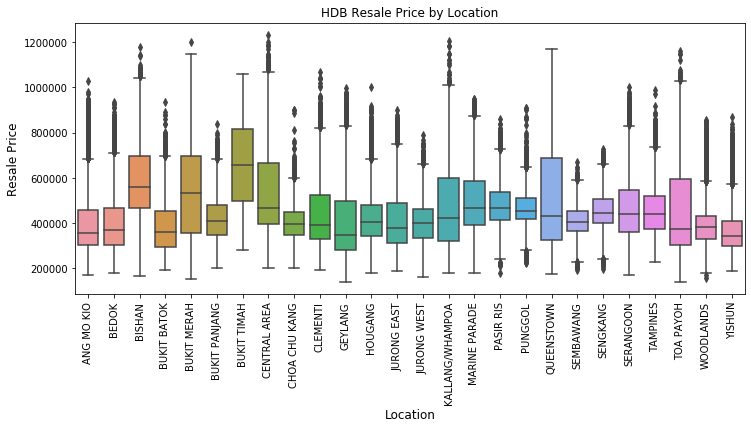

In [177]:
# HDB
def catPlot(var):
    f, ax = plt.subplots(figsize=(12, 5))
    fig = sns.boxplot(x=var, y="resale_price", data=dfhdb)
    fig.set_title('HDB Resale Price by Location',fontsize=12)
    fig.set_xlabel('Location',fontsize=12)
    fig.set_ylabel('Resale Price',fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

catPlot('town')

#### Plotting Resale Price vs Area

Text(0, 0.5, 'Resale Price')

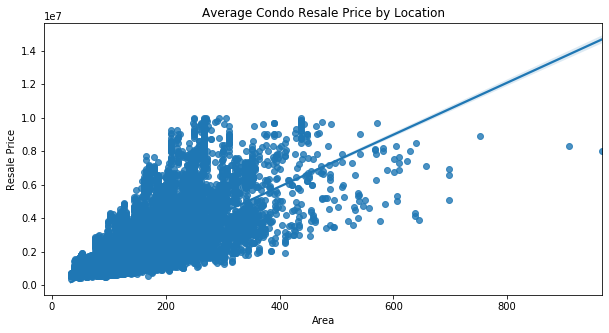

In [181]:
#Condo
plt.figure (figsize = (10,5))
sns.regplot(x="Area", y="Transacted Price", data=dfcondo).set_title('Average Condo Resale Price by Location',fontsize=12)
plt.xlabel("Area")
plt.ylabel("Resale Price")

Text(0, 0.5, 'Resale Price')

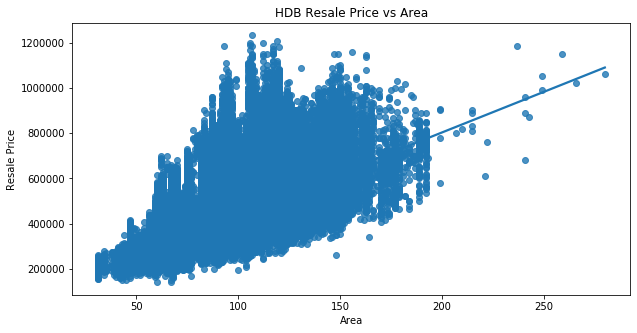

In [180]:
#HDB
plt.figure (figsize = (10,5))
sns.regplot(x="floor_area_sqm", y="resale_price", data=dfhdb).set_title('HDB Resale Price vs Area',fontsize=12)
plt.xlabel("Area")
plt.ylabel("Resale Price")

#### Plotting Resale Price vs Floor

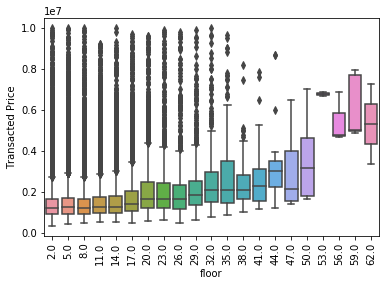

In [104]:
#Condo
fig.set_size_inches(20,20)
sns.boxplot(data=dfcondo,y="Transacted Price",x="floor",orient="v")
plt.xticks(rotation=90)
plt.show()

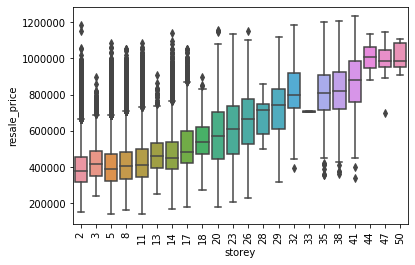

In [133]:
#HDB
fig.set_size_inches(15, 10)
sns.boxplot(data=dfhdb,y="resale_price",x="storey",orient="v")
plt.xticks(rotation=90)
plt.show()

#### Plotting resale price vs Age

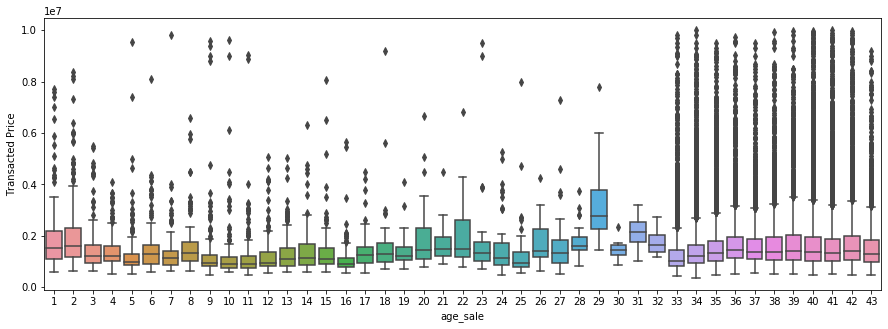

In [127]:
#Condo
fig=plt.figure(figsize=(15,5))
sns.boxplot(data=dfcondo,y="Transacted Price",x='age_sale')

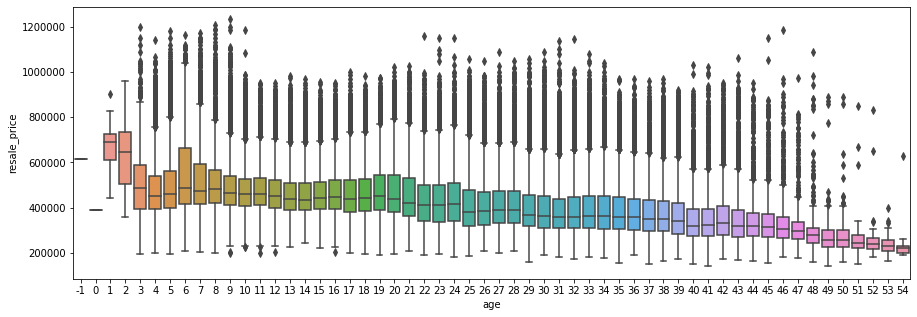

In [128]:
#HDB
fig=plt.figure(figsize=(15,5))
sns.boxplot(data=dfhdb,y="resale_price",x='age')


# Section 2: Condo price analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("Jan10-Aug20_resale.csv")

In [4]:
#Selecting resale condominium
df=df[df['No. of Units']==1]
df=df[df['Property Type']=='Condominium']
df=df[df['Type of Sale'] =='Resale']

"""Since Daniel is considering between resale HDB and condo, we remove property
transacted above $10 million as it is unlikely for someone with that budget to look at HDB for investment"""
df=df[df['Transacted Price']<10000000]

In [5]:
df = df[df['Tenure'] !='N.A.']
df['Tenure'] = df['Tenure'].str.split(' F').str[0]
df['Tenure'] = df['Tenure'].str.replace('Years Leasehold','Yrs')
#selecting common tenure
df = df[df['Tenure']!='101 Yrs']
df = df[df['Tenure']!='103 Yrs']
df = df[df['Tenure']!='946 Yrs']
df = df[df['Tenure']!='956 Yrs']
#removing condo with floors unknown and basement units
df = df[df['floor'] > 0]

In [6]:
df['Completion Date'] = df['Completion Date'].astype(int)
df['Sale Date']=pd.to_datetime(df['Sale Date']).dt.to_period('M')
df['Sale_year']=df['Sale Date'].dt.year
df['age_sale'] =df['Sale_year'] - df['Completion Date']
df['age_2020'] = 2020 -df['Completion Date']
df['age_2023'] = 2023 -df['Completion Date']

In [7]:
#Setting floors into range
df = df.replace({'floor':{1:2,  2:2,  3:2,  4:5,  5:5,  6:5,  7:8,  8:8,  9:8, 10:11, 11:11, 12:11,
       13:14, 14:14, 15:14, 16:17, 17:17, 18:17, 19:20, 20:20, 21:20, 22:23, 23:23, 24:23, 25:26,
       26:26, 27:26, 28:29, 29:29, 30:29, 31:32, 32:32, 33:32, 34:35, 35:35, 36:35, 37:38, 38:38,
       39:38, 40:41, 41:41, 42:41, 43:44, 44:44, 45:44, 46:47, 47:47, 48:47, 49:50, 50:50, 51:50,
       52:53, 54:53, 55:56, 56:56, 57:56, 58:59, 59:59, 60:59, 61:62, 62:62, 65:65}})

In [8]:
df_mlr = df[['Area', 'Transacted Price','Tenure',
       'Postal District', 'floor', 'age_sale','age_2020','age_2023','Sale_year']]

In [9]:
df_mlr = (df_mlr.groupby(['Sale_year',pd.Grouper(key='Area'),pd.Grouper(key='Tenure'),pd.Grouper(key='floor'),pd.Grouper(key='age_sale'),pd.Grouper(key='Postal District')])
          .agg({'Transacted Price':'median','age_2020':pd.Series.unique,'age_2023':pd.Series.unique}))

In [10]:
df_mlr = df_mlr.reset_index()

In [11]:
df_mlr = df_mlr.rename(columns={'Transacted Price':'median_price','Postal District':'district'})
df_mlr['floor'] = df_mlr['floor'].astype(int)

In [12]:
#logging target variables
df_mlr['ln_price'] = np.log10(df_mlr['median_price'])

## EDA

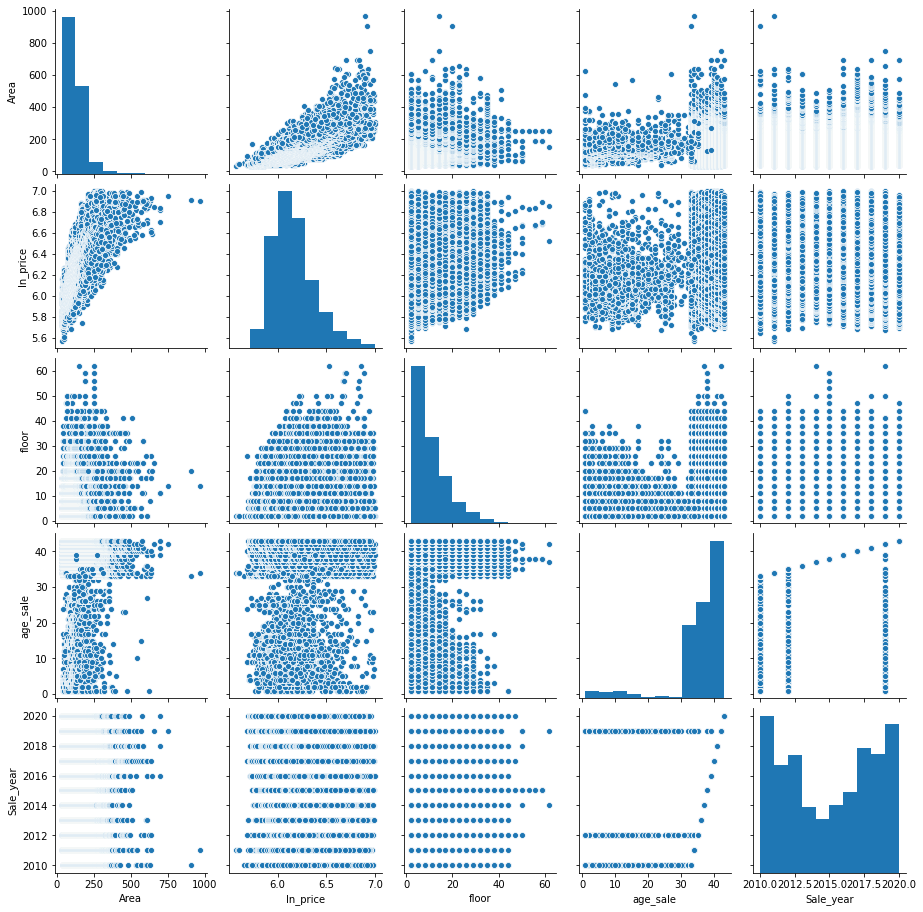

In [13]:
sns.pairplot(df_mlr[['Area', 'ln_price','floor', 'age_sale','Sale_year']])

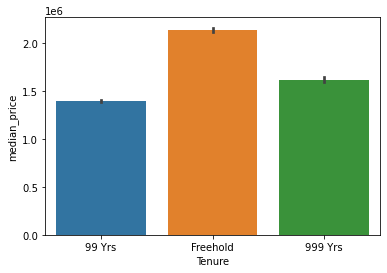

In [14]:
sns.barplot(x=df_mlr['Tenure'],y=df_mlr['median_price'])

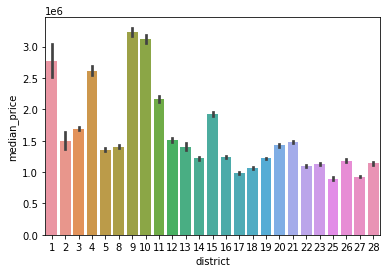

In [15]:
sns.barplot(x=df_mlr['district'],y=df_mlr['median_price'])

## ARIMA

In [16]:
df_arima=pd.read_csv("Jan10-Aug20_resale.csv")
df_arima = df_arima[['Sale Date','Postal District','Transacted Price']]
df_arima['Sale Date'] = pd.to_datetime(df_arima['Sale Date'])
df_arima = df_arima.set_index(pd.DatetimeIndex(df_arima['Sale Date']))
df_arima = df_arima.drop('Sale Date',axis = 1)
df_arima = (df_arima.groupby(['Postal District']).resample('M')['Transacted Price'].median().reset_index(level=0))

In [17]:
#Removing district with null values
df_arima = df_arima[df_arima['Postal District'] != 1]
df_arima = df_arima[df_arima['Postal District'] != 2]
df_arima = df_arima[df_arima['Postal District'] != 8]
df_arima = df_arima[df_arima['Postal District'] != 13]
df_arima = df_arima[df_arima['Postal District'] != 26]

In [18]:
price = df_arima.drop('Postal District',axis=1)

In [19]:
#test shows price is stationary
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(price)
dftest

(-2.7413242285066146,
 0.06715626057725504,
 27,
 2532,
 {'1%': -3.4329352851231945,
  '5%': -2.862682171580326,
  '10%': -2.5673780210899224},
 69869.68873142751)

In [20]:
district_dfs = []
district_list = df_arima['Postal District'].unique()

for x in district_list:
    district_dfs.append(pd.DataFrame(df_arima[df_arima['Postal District']==x][['Transacted Price']].copy()))

In [21]:
import itertools
p = d = q = range(0,2)
# Generate all different combinations of p, d and q between (0,2)
pdq = list(itertools.product(p,d,q))


In [22]:
ans = []
for df, name in zip(district_dfs, district_list):
    for para1 in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order = para1,                 
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            output = mod.fit()
            ans.append([name, para1, output.aic])
        except:
            continue

In [23]:
#Filtering best p,d,q
result = pd.DataFrame(ans, columns = ['name','pdq','AIC'])
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [24]:
#Make prediction and compare with actual values
summary_table = pd.DataFrame()
District_code = []
MSE_Value = []
models = []
for name, pdq, df in zip(best_para['name'], best_para['pdq'], district_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)                              
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions for month of August 2020
    pred_dynamic = output.get_prediction(pd.to_datetime('2020-08-31'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    district_forecasted = pred_dynamic.predicted_mean
    district_truth = df_arima['2020-08-31':]['Transacted Price']
    
    sqrt_mse = np.sqrt(((district_forecasted - district_truth)**2).mean())
    
    District_code.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Postal District'] = District_code
summary_table['Sqrt_MSE'] = MSE_Value

In [25]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []


for district, output, df in zip(District_code, models, district_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    current.append(df['2020-08']['Transacted Price'][0])
    forecast_3Yr.append(forecast_3)
    
forecast_table['Postal Code'] = District_code
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['Expected Gain']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']*100

In [26]:
arima_district_roi = forecast_table[['Postal Code','Current Value','Expected Gain']]
arima_district_roi[arima_district_roi['Expected Gain']>0].sort_values('Expected Gain', ascending=False)

,Postal Code,Current Value,Expected Gain
5,11,1940000.0,17.984469
15,22,968000.0,12.053129
19,28,972180.0,7.888023
7,14,925000.0,6.420648
8,15,1800000.0,5.814561
17,25,805000.0,3.289788
14,21,1432945.0,1.654640
4,10,2810000.0,1.637174


## Data Processing for Multi-Linear Regression

In [27]:
df_mlr = pd.get_dummies(data=df_mlr, columns=['district'],drop_first=True)
df_mlr = pd.get_dummies(data=df_mlr, columns=['Tenure'],drop_first=False)
df_mlr = df_mlr.drop('Tenure_999 Yrs', axis = 1)

In [28]:
#extracting modeling dataset
data = df_mlr.drop(['age_2020','age_2023','median_price'],axis=1)

In [29]:
df_train, df_test = train_test_split(data, test_size = 0.3, random_state=42)
X_train = df_train.drop('ln_price',axis=1)
y_train = df_train['ln_price']
X_test = df_test.drop('ln_price',axis=1)
y_test = df_test['ln_price']

In [30]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [31]:
#predict prices of X_test
y_pred = lm.predict(X_test)

#evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print(r2)

0.8370922128143026


## Feature selection

The OLS results showed that age's coefficient of almost zero, implying it has minimal effect on price even though it is statistically significant. Domain knowledge considers age as an important factor. As such, exploration of age's interaction with numerical variables and tenure was carried out.

In [32]:
import statsmodels.formula.api as smf
ins_model = smf.ols('ln_price ~ Sale_year+ floor+ Area+ age_sale+ Q("Tenure_99 Yrs")+Tenure_Freehold+ district_2+ district_3+ district_4+ district_5+ district_8+ district_9+ district_10+ district_11+ district_12+ district_13+ district_14+ district_15+ district_16+ district_17+ district_18+ district_19+ district_20+ district_21+ district_22+ district_23+ district_25+ district_26+ district_27+ district_28', data =data).fit()
ins_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     7551.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        06:55:23   Log-Likelihood:                 44494.
No. Observations:               43681   AIC:                        -8.893e+04
Df Residuals:                   43650   BIC:                        -8.866e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -12.9237      0.321    -40.230      0.000     -13.553     -12.294
Sale_year              0.0094      0.000     58.799      0.000       0.009       0.010
floor                  0.0029   6.17e-05     47.320      0.000       0.003       0.003
Area                   0.0023      8e-06    287.190      0.000       0.002       0.002
age_sale               0.0003   6.45e-05      4.584      0.000       0.000       0.000
Q("Tenure_99 Yrs")    -0.0318      0.002    -16.250      0.000      -0.036      -0.028
Tenure_Freehold        0.0312      0.002     16.203      0.000       0.027       0.035
district_2            -0.1852      0.015    -12.375      0.000      -0.215      -0.156
district_3            -0.1384      0.007    -20.484      0.000      -0.152      -0.125
district_4            -0.0720      0.007    -10.455      0.000      -0.085      -0.058
district_5            -0.2450      0.007    -36.473      0.000      -0.258      -0.232
district_8            -0.1954      0.007    -27.794      0.000      -0.209      -0.182
district_9             0.0006      0.007      0.095      0.924      -0.012       0.014
district_10           -0.0520      0.007     -7.866      0.000      -0.065      -0.039
district_11           -0.1293      0.007    -19.253      0.000      -0.142      -0.116
district_12           -0.2261      0.007    -31.637      0.000      -0.240      -0.212
district_13           -0.2323      0.008    -29.854      0.000      -0.248      -0.217
district_14           -0.2726      0.007    -39.403      0.000      -0.286      -0.259
district_15           -0.1645      0.007    -24.914      0.000      -0.177      -0.152
district_16           -0.2675      0.007    -40.194      0.000      -0.281      -0.254
district_17           -0.3743      0.007    -54.197      0.000      -0.388      -0.361
district_18           -0.3195      0.007    -47.206      0.000      -0.333      -0.306
district_19           -0.2645      0.007    -39.735      0.000      -0.278      -0.251
district_20           -0.2303      0.007    -33.954      0.000      -0.244      -0.217
district_21           -0.2264      0.007    -34.035      0.000      -0.239      -0.213
district_22           -0.2877      0.007    -41.740      0.000      -0.301      -0.274
district_23           -0.3124      0.007    -47.333      0.000      -0.325      -0.299
district_25           -0.3650      0.007    -49.147      0.000      -0.380      -0.350
district_26           -0.3015      0.007    -41.320      0.000      -0.316      -0.287
district_27           -0.3587      0.007    -51.546      0.000      -0.372      -0.345
district_28           -0.3238      0.007    -43.569      0.000      -0.338      -0.309
==============================================================================
Omnibus:                     6213.298   Durbin

In [33]:
#interaction terms exploration, focus is on age
X_interaction = X_train[['Tenure_99 Yrs', 'Tenure_Freehold', 'age_sale', 'Area', 'Sale_year', 'floor']]

In [34]:
y_train_interaction = y_train.copy()
y_train_interaction = y_train_interaction.reset_index()
y_train_interaction = y_train_interaction['ln_price']

In [35]:
from sklearn.preprocessing import PolynomialFeatures
#generating interaction terms
x_interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(X_interaction)
#creating a new dataframe with the interaction terms included
interaction_df = pd.DataFrame(x_interaction, columns = ['Tenure_99 Yrs','Tenure_Freehold', 'age_sale', 'Area', 'sale_year', 'floor',
                                                       'age_sale:Tenure_99 Yrs','age_sale:Tenure_Freehold','age_sale:Area','age_sale:Sale_year',
                                                       'age_sale:floor','Tenure_Freehold:Tenure_99 Yrs','Area:Tenure_Freehold',
                                                        'Sale_year:Tenure_Freehold','ln_floor:Tenure_Freehold', 'Tenure_99 Yrs:Sale_year',
                                                       'Tenure_99 Yrs:floor','Area:Tenure_99 Yrs','Area:floor','Area:Sale_year','floor:Sale_year'])

In [36]:
interaction_model = sm.OLS(y_train_interaction, interaction_df).fit()

Results showed that age interaction with 99 years leasehold tenure and sale year is the most statistically significant.

In [37]:
interaction_model.pvalues#[interaction_model.pvalues < 0.000005]

Tenure_99 Yrs                     7.849870e-09
Tenure_Freehold                   2.340091e-21
age_sale                          6.814020e-10
Area                              5.260650e-12
sale_year                         0.000000e+00
floor                             5.764454e-02
age_sale:Tenure_99 Yrs            2.258562e-13
age_sale:Tenure_Freehold          3.978369e-06
age_sale:Area                     2.595581e-06
age_sale:Sale_year                1.003356e-08
age_sale:floor                    3.043091e-01
Tenure_Freehold:Tenure_99 Yrs     4.780760e-05
Area:Tenure_Freehold              6.209195e-15
Sale_year:Tenure_Freehold         3.144932e-21
ln_floor:Tenure_Freehold          3.797628e-09
Tenure_99 Yrs:Sale_year           2.926402e-06
Tenure_99 Yrs:floor               9.351046e-10
Area:Tenure_99 Yrs                1.119294e-01
Area:floor                        7.674251e-13
Area:Sale_year                   5.628264e-124
floor:Sale_year                   4.678323e-02
dtype: float6

In [38]:
ins_model1 = smf.ols('ln_price ~ Sale_year+ floor+ Area+ age_sale+ age_sale*Sale_year+age_sale*Q("Tenure_99 Yrs")+ Q("Tenure_99 Yrs")+Tenure_Freehold+ district_2+ district_3+ district_4+ district_5+ district_8++ district_9+district_10+ district_11+ district_12+ district_13+ district_14+ district_15+ district_16+ district_17+ district_18+ district_19+ district_20+ district_21+ district_22+ district_23+ district_25+ district_26+ district_27+ district_28', data =data).fit()
ins_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     7155.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        06:55:23   Log-Likelihood:                 44691.
No. Observations:               43681   AIC:                        -8.932e+04
Df Residuals:                   43648   BIC:                        -8.903e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -38.5570      1.376    -28.014      0.000     -41.255     -35.859
Sale_year                       0.0222      0.001     32.374      0.000       0.021       0.023
floor                           0.0029   6.14e-05     47.472      0.000       0.003       0.003
Area                            0.0023   7.96e-06    288.074      0.000       0.002       0.002
age_sale                        0.6690      0.035     19.174      0.000       0.601       0.737
age_sale:Sale_year             -0.0003   1.73e-05    -19.157      0.000      -0.000      -0.000
Q("Tenure_99 Yrs")             -0.0166      0.004     -3.951      0.000      -0.025      -0.008
age_sale:Q("Tenure_99 Yrs")    -0.0004      0.000     -3.979      0.000      -0.001      -0.000
Tenure_Freehold                 0.0314      0.002     16.361      0.000       0.028       0.035
district_2                     -0.1890      0.015    -12.680      0.000      -0.218      -0.160
district_3                     -0.1382      0.007    -20.540      0.000      -0.151      -0.125
district_4                     -0.0716      0.007    -10.450      0.000      -0.085      -0.058
district_5                     -0.2450      0.007    -36.636      0.000      -0.258      -0.232
district_8                     -0.1945      0.007    -27.787      0.000      -0.208      -0.181
district_9                      0.0011      0.007      0.164      0.869      -0.012       0.014
district_10                    -0.0517      0.007     -7.860      0.000      -0.065      -0.039
district_11                    -0.1291      0.007    -19.306      0.000      -0.142      -0.116
district_12                    -0.2260      0.007    -31.767      0.000      -0.240      -0.212
district_13                    -0.2305      0.008    -29.763      0.000      -0.246      -0.215
district_14                    -0.2721      0.007    -39.517      0.000      -0.286      -0.259
district_15                    -0.1644      0.007    -25.006      0.000      -0.177      -0.152
district_16                    -0.2670      0.007    -40.300      0.000      -0.280      -0.254
district_17                    -0.3731      0.007    -54.265      0.000      -0.387      -0.360
district_18                    -0.3191      0.007    -47.371      0.000      -0.332      -0.306
district_19                    -0.2641      0.007    -39.857      0.000      -0.277      -0.251
district_20                    -0.2295      0.007    -33.999      0.000      -0.243      -0.216
district_21                    -0.2260      0.007    -34.138      0.000      -0.239      -0.213
district_22                    -0.2876      0.007    -41.924      0.000      -0.301      -0.274
district_23                    -0.3119      0.007    -47.473      0.000      -0.325      -0.299
district_25

### Linear Regression

In [39]:
#Re-defining training and testing dataset to include interaction terms
X_train1 = X_train.copy()
X_train1 = X_train1.drop('district_9',axis=1)
X_train1['agextenure99'] = X_train['age_sale']*X_train['Tenure_99 Yrs']
X_train1['agexsaleyear'] = X_train['age_sale']*X_train['Sale_year']
X_test1 = X_test.copy()
X_test1 = X_test1.drop('district_9',axis=1)
X_test1['agextenure99'] = X_test1['age_sale']*X_test1['Tenure_99 Yrs']
X_test1['agexsaleyear'] = X_test1['age_sale']*X_test1['Sale_year']

In [40]:
lm_final = LinearRegression()
lm_final.fit(X_train1,y_train)

LinearRegression()

In [41]:
#predict prices of X_test1
y_pred = lm_final.predict(X_test1)

#evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test,y_pred)
print(r2)

0.8385109915774248


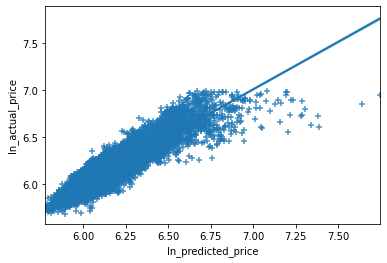

In [42]:
x, y = pd.Series(y_pred, name="ln_predicted_price"), pd.Series(y_test, name="ln_actual_price")
ax = sns.regplot(x=x, y=y, marker="+")

#sns.regplot(y_test, name='',y_pred)


In [43]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(10**y_test, 10**y_pred))

mape = np.mean(np.abs(10**y_test - 10**y_pred)/np.abs(10**y_pred))*100
print('RMSE: '+str(rmse))
print('MAPE: '+str(mape))


RMSE: 879176.0309483402
MAPE: 15.274122841023624


## Ridge

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()

parameters = {'alpha':[0.01,0.05,0.1,0.5,1,5,10,20]}

ridge_regressor = GridSearchCV(ridge,parameters, scoring='r2', cv=5)

ridge_regressor.fit(X_train1,y_train)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.01}
0.8398140797602224


## Lasso

In [45]:
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha':[0.01,0.05,0.1,0.5,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'r2', cv=5)
lasso_regressor.fit(X_train1,y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.01}
0.6592122841400503


### 5-Fold CV
From r2 scores above, linear model is chosen as its r2 score is similar to ridge model.
A 5-Fold cross validation mean r2 score for linear model is similar to linear model built above.

In [46]:
#CV score mean is close to model r2 score
lm2 = LinearRegression()
scores = cross_val_score(lm2, X_train1, y_train, scoring = 'r2',cv=5)
np.mean(scores)

0.8398141413722267

## Predictions

In [47]:
X_2020 = df_mlr[X_train.columns]
X_2020 = X_2020.drop('district_9',axis=1)

In [48]:
X_2020['Sale_year'] = 2020
X_2020['age_sale'] = df_mlr['age_2020']
X_2020['agextenure99'] = X_2020['age_sale']*X_2020['Tenure_99 Yrs']
X_2020['agexsaleyear'] = X_2020['age_sale']*X_2020['Sale_year']

In [49]:
y_pred_2020 = lm_final.predict(X_2020)

In [50]:
X_2023 = X_2020

In [51]:
X_2023['Sale_year'] = 2023
X_2023['age_sale'] = df_mlr['age_2023']
X_2023['agextenure99'] = X_2023['age_sale']*X_2023['Tenure_99 Yrs']
X_2023['agexsaleyear'] = X_2023['age_sale']*X_2023['Sale_year']

In [52]:
y_pred_2023 = lm_final.predict(X_2023)

In [53]:
data_gain = df_mlr[X_train.columns]
data_gain['median_price'] = df_mlr['median_price']
data_gain['age_sale'] = df_mlr['age_2020']

In [54]:
data_gain['Predicted_price2023'] = 10**y_pred_2023
data_gain['Predicted_price2020'] = 10**y_pred_2020

In [55]:
data_gain['Gain'] = data_gain['Predicted_price2023']-data_gain['Predicted_price2020']

In [56]:
pd.options.display.float_format = "{:.5f}".format
data_gain['percent_gain'] = (data_gain['Gain']/data_gain['Predicted_price2020'])*100

In [57]:
data_gain.sort_values(['percent_gain', 'Predicted_price2020'], ascending=[False, True]).head()

,Sale_year,Area,floor,age_sale,district_2,district_3,district_4,district_5,district_8,district_9,...,district_26,district_27,district_28,Tenure_99 Yrs,Tenure_Freehold,median_price,Predicted_price2023,Predicted_price2020,Gain,percent_gain
39814,2019,121,32,2,0,0,0,0,0,1,...,0,0,0,0,1,4288000.00000,4403622.86094,3878842.64047,524780.22047,13.52930
37579,2019,47,5,2,0,0,0,0,0,1,...,0,0,0,0,1,1545000.00000,2499943.91734,2202025.32587,297918.59147,13.52930
37581,2019,47,8,2,0,0,0,0,0,1,...,0,0,0,0,1,1578190.00000,2549978.47348,2246097.25845,303881.21503,13.52930
41223,2019,210,17,3,0,0,0,0,0,0,...,0,0,0,0,1,8084000.00000,5565088.93465,4913093.80244,651995.13221,13.27056
40897,2019,165,20,3,0,0,0,0,0,0,...,0,0,0,0,1,6393600.00000,4483927.57993,3958599.23574,525328.34419,13.27056


In [58]:
data_gain[data_gain['Predicted_price2020'].between(700000, 1000000)].sort_values(['percent_gain', 'Predicted_price2023'], ascending=[False, True]).head()

,Sale_year,Area,floor,age_sale,district_2,district_3,district_4,district_5,district_8,district_9,...,district_26,district_27,district_28,Tenure_99 Yrs,Tenure_Freehold,median_price,Predicted_price2023,Predicted_price2020,Gain,percent_gain
37786,2019,64,8,2,0,0,0,0,0,0,...,0,1,0,1,0,770000.00000,1088020.64935,961735.86018,126284.78917,13.13092
37506,2019,43,8,2,0,0,0,0,0,0,...,0,0,0,1,0,635000.00000,1064196.28656,940676.75248,123519.53409,13.13092
37545,2019,45,11,3,0,0,0,0,0,0,...,0,0,0,1,0,638000.00000,1088132.82137,964032.07841,124100.74296,12.87309
37591,2019,48,11,4,0,0,0,0,0,0,...,0,0,0,1,0,650000.00000,1096508.05846,973671.15958,122836.89888,12.61585
37858,2019,69,2,4,0,0,0,0,0,0,...,0,1,0,1,0,742000.00000,1056351.56932,938013.22251,118338.34681,12.61585


In [59]:
data_gain[data_gain['Predicted_price2020'].between(1000000, 5000000)].sort_values(['percent_gain', 'Predicted_price2023'], ascending=[False, True]).head()

,Sale_year,Area,floor,age_sale,district_2,district_3,district_4,district_5,district_8,district_9,...,district_26,district_27,district_28,Tenure_99 Yrs,Tenure_Freehold,median_price,Predicted_price2023,Predicted_price2020,Gain,percent_gain
39814,2019,121,32,2,0,0,0,0,0,1,...,0,0,0,0,1,4288000.00000,4403622.86094,3878842.64047,524780.22047,13.52930
37579,2019,47,5,2,0,0,0,0,0,1,...,0,0,0,0,1,1545000.00000,2499943.91734,2202025.32587,297918.59147,13.52930
37581,2019,47,8,2,0,0,0,0,0,1,...,0,0,0,0,1,1578190.00000,2549978.47348,2246097.25845,303881.21503,13.52930
41223,2019,210,17,3,0,0,0,0,0,0,...,0,0,0,0,1,8084000.00000,5565088.93465,4913093.80244,651995.13221,13.27056
40897,2019,165,20,3,0,0,0,0,0,0,...,0,0,0,0,1,6393600.00000,4483927.57993,3958599.23574,525328.34419,13.27056


# Section 3: HDB price analysis

# Logic of problem solving (HDB)

Phase 1: get most important features for 3-year price change - (price:price per area)
1. STEP 1: for each year, for each different categories, get the median price; calculate the change percentage of 3-year saling price for each year, which is $(P_{t+3}-P_t)/P_t$ (t=2010,2011,...2017）
3. STEP 2: fixed effect regression - find top 5 categories

Phase 2: predict 2023 price in the 5 categories
1. STEP 1: extract monthly data for the 5 categories
2. STEP 2: apply Holt Winter's method to forecast Aug 2023 price
3. STEP 3: calculate $(P_{2023}-P_{2020})/P_{2020}$

## 0. Data cleaning

In [1]:
# Libraries
import numpy as np
import pandas as pd
from datetime import datetime
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Read .csv
path_hdb = r'C:\Users\Mingyu\Desktop\HDB-data'
all_files_hdb = glob.glob(path_hdb + "/*.csv")
hdb = pd.concat((pd.read_csv(f,index_col=None, header=0) for f in all_files_hdb),axis=0, ignore_index=True)


In [3]:
# Take a look
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,NaN
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,NaN
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,NaN
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,NaN
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,NaN


In [4]:
# Data preprocessing

# Year & Month
hdb['month'] = pd.to_datetime(hdb['month'])
hdb.rename(columns={'month':'month_year'}, inplace=True) 
hdb['year'] = hdb['month_year'].dt.year
hdb['month']= hdb['month_year'].dt.month

# Age
hdb['age'] = hdb['year'] - hdb['lease_commence_date']

# Category vars
categoryVariableList = ["town","flat_type","flat_model"]
for var in categoryVariableList:
    hdb[var] = hdb[var].astype("category")

# Floor
hdb['storey_range']= hdb['storey_range'].astype(str)
hdb['floor_min'] = hdb['storey_range'].str[:2].astype(int)
hdb['floor_max'] = hdb['storey_range'].str[6:].astype(int)
col = hdb.loc[: , "floor_min":"floor_max"]
hdb['floor'] = col.median(axis=1).astype(int)

# Price per area
hdb['price_per']=hdb['resale_price']/hdb['floor_area_sqm']

# Drop useless cols
dropList = ['remaining_lease','lease_commence_date','storey_range','floor_min','floor_max']
for var in dropList:
    hdb = hdb.drop(var, axis=1)

In [5]:
hdb=hdb[hdb['year']>=2015]

In [6]:
# Take a look again
hdb.sort_values(by=['year','month']).head()

,month_year,town,flat_type,block,street_name,floor_area_sqm,flat_model,resale_price,year,month,age,floor,price_per
369651,2015-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,60.0,Improved,255000.0,2015,1,29,8,4250.000000
369652,2015-01-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,68.0,New Generation,275000.0,2015,1,34,2,4044.117647
369653,2015-01-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,69.0,New Generation,285000.0,2015,1,35,2,4130.434783
369654,2015-01-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,68.0,New Generation,290000.0,2015,1,36,2,4264.705882
369655,2015-01-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,68.0,New Generation,290000.0,2015,1,35,8,4264.705882


In [7]:
hdb.dtypes

month_year        datetime64[ns]
town                    category
flat_type               category
block                     object
street_name               object
floor_area_sqm           float64
flat_model              category
resale_price             float64
year                       int64
month                      int64
age                        int64
floor                      int32
price_per                float64
dtype: object

## 1.0 Exploratory Data Analysis

#### Box plots

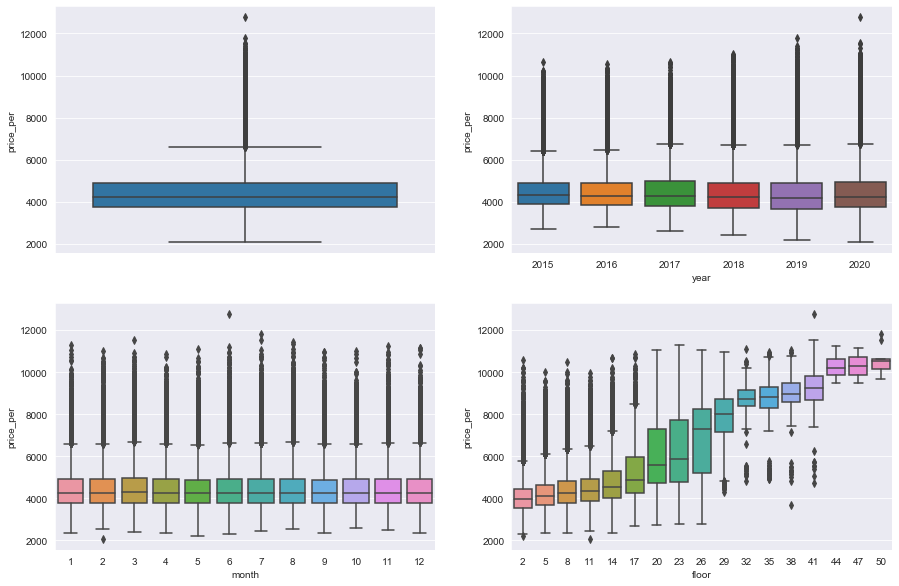

In [132]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15, 10)
sns.boxplot(data=hdb,y="price_per",orient="v",ax=axes[0][0])
sns.boxplot(data=hdb,y="price_per",x="year",orient="v",ax=axes[0][1])
sns.boxplot(data=hdb,y="price_per",x="month",orient="v",ax=axes[1][0])
sns.boxplot(data=hdb,y="price_per",x="floor",orient="v",ax=axes[1][1])
plt.show()


#### Scatter plots

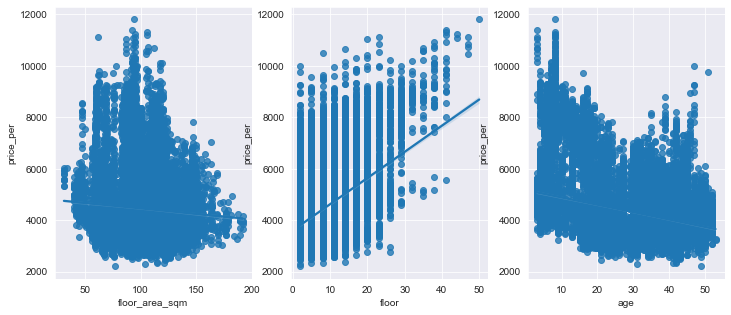

In [133]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="floor_area_sqm", y="price_per", data=hdb[hdb['year']==2019],ax=ax1)
sns.regplot(x="floor", y="price_per", data=hdb[hdb['year']==2019],ax=ax2)
sns.regplot(x="age", y="price_per", data=hdb[hdb['year']==2019],ax=ax3)
plt.show()

#### Correlation matrix

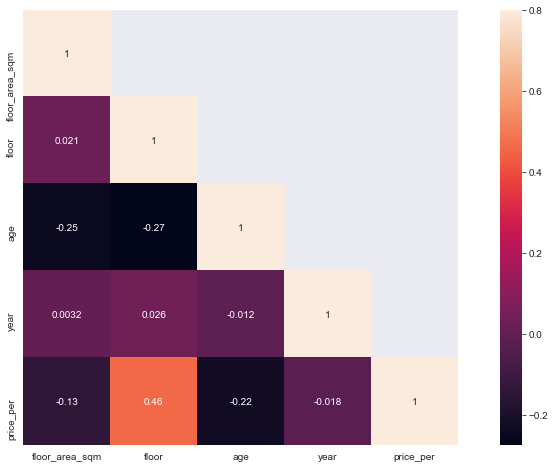

In [134]:
corrMatt = hdb[["floor_area_sqm","floor","age","year","price_per"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(15,8)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

#### Other catogorical factors: flat_type, town, flat_model

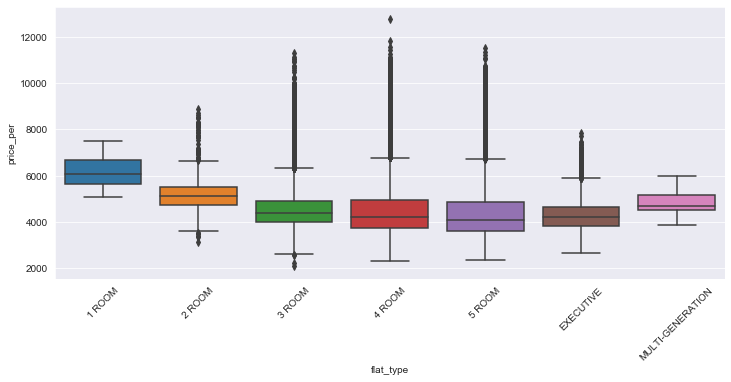

In [135]:
def catPlot(var):
    f, ax = plt.subplots(figsize=(12, 5))
    fig = sns.boxplot(x=var, y="price_per", data=hdb)
    plt.xticks(rotation=45)
    plt.show()

catPlot('flat_type')


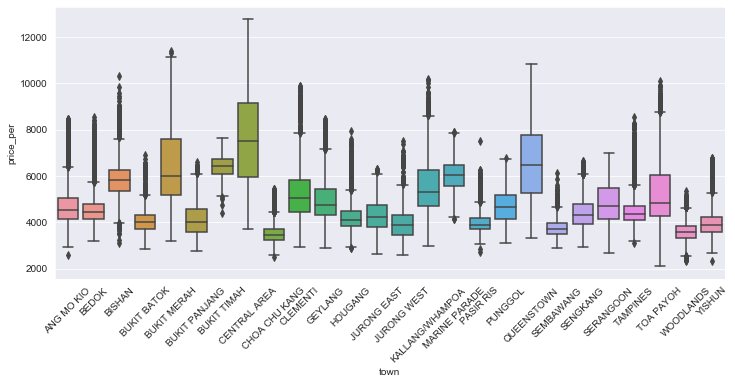

In [136]:
catPlot('town')

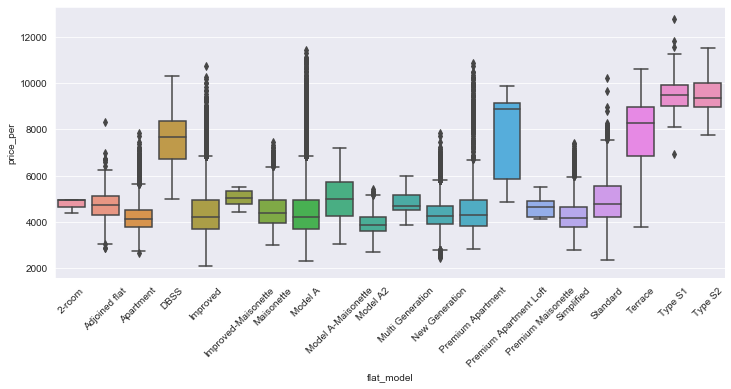

In [137]:
catPlot('flat_model')

### 'flat_model' OR 'flat_type'?

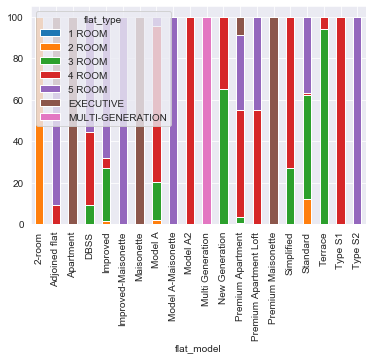

In [138]:
cnt_df = hdb.groupby(['flat_model','flat_type']).size().to_frame('cnt').reset_index()
tmp = cnt_df.set_index(['flat_model','flat_type']).groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()
tmp.columns = tmp.columns.levels[1]
tmp.head()
tmp.plot(kind='bar',stacked=True)
plt.show()

**So we keep flat type since it is a more general category.**

### Box-cox Price change vs features

In [139]:
def catPlot2(var):
    f, ax = plt.subplots(figsize=(12, 5))
    fig = sns.boxplot(x=var, y="box_price_change", data=yearly_price)
    plt.xticks(rotation=45)
    plt.show()

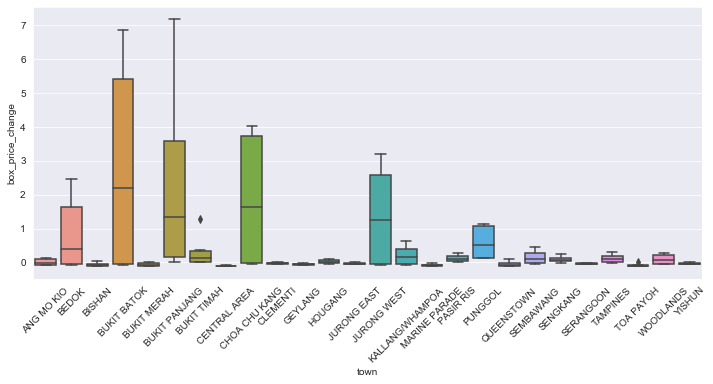

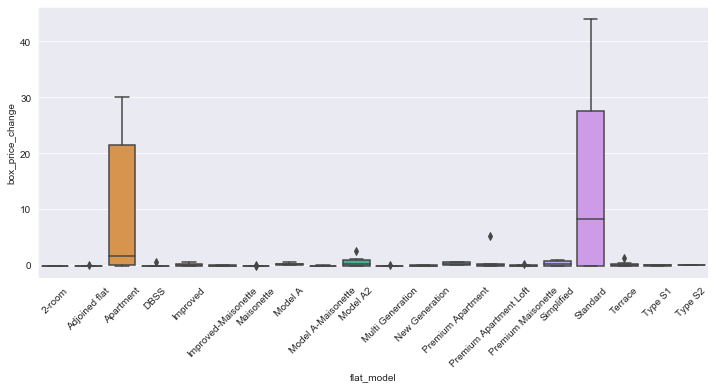

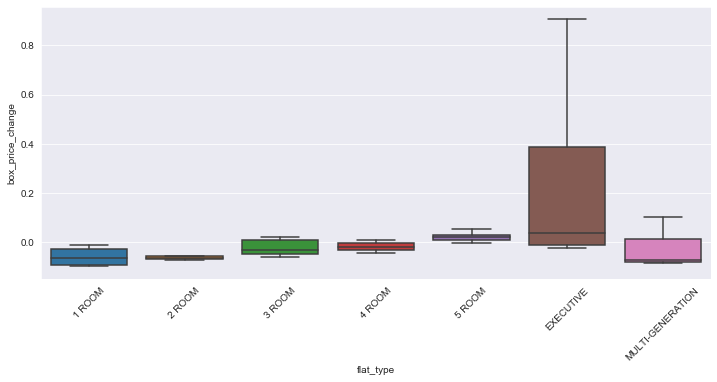

In [140]:
from scipy import stats
categoryVariableList = ["town","flat_model","flat_type"]

for var in categoryVariableList:
    yearly_price = hdb.groupby([var,'year'])['price_per'].median().reset_index(name='yearly_price')
    yearly_price['price_change']=yearly_price.yearly_price.diff(3).shift(-3).dropna()
    yearly_price['price_pct_change']=yearly_price['price_change']/yearly_price['yearly_price']
    yearly_price['box_price_change'], lmbda = stats.boxcox(yearly_price.price_pct_change+1)
    catPlot2(var)
    

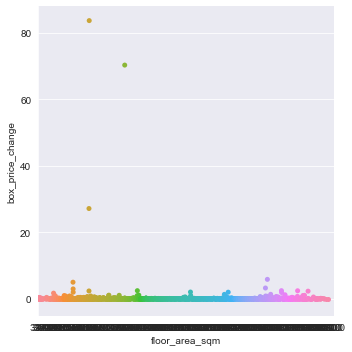

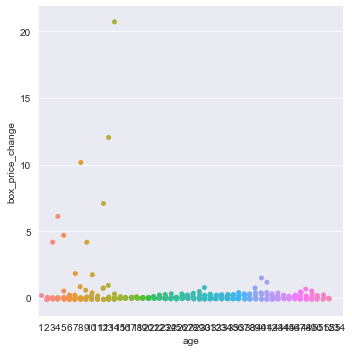

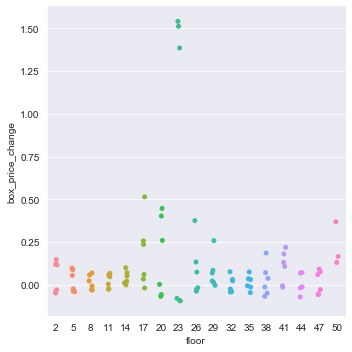

In [187]:
numericalVariableList = ['floor_area_sqm','age','floor']
for var in numericalVariableList :
    yearly_price = hdb.groupby([var,'year'])['price_per'].median().reset_index(name='yearly_price')
    yearly_price['price_change']=yearly_price.yearly_price.diff(3).shift(-3).dropna()
    yearly_price['price_pct_change']=yearly_price['price_change']/yearly_price['yearly_price']
    yearly_price['box_price_change'], lmbda = stats.boxcox(yearly_price.price_pct_change+1)
    sns.catplot(x=var, y="box_price_change", data= yearly_price)
    plt.show()

## 2. Linear Regression

In [8]:
def myround(x, y):
    base=y
    return base * round(x/base)

# round age & floor
hdb['age']=myround(hdb['age'],10)
hdb['floor']=myround(hdb['floor'],10)

### Cut 2017 & 2020 w/ OLS

In [9]:
hdb_best=hdb[(hdb['year']==2017)|(hdb['year']==2020)]
hdb_best.head()

,month_year,town,flat_type,block,street_name,floor_area_sqm,flat_model,resale_price,year,month,age,floor,price_per
406804,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,44.0,Improved,232000.0,2017,1,40.0,10.0,5272.727273
406805,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,67.0,New Generation,250000.0,2017,1,40.0,0.0,3731.343284
406806,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,67.0,New Generation,262000.0,2017,1,40.0,0.0,3910.447761
406807,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,68.0,New Generation,265000.0,2017,1,40.0,0.0,3897.058824
406808,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,67.0,New Generation,265000.0,2017,1,40.0,0.0,3955.223881


In [10]:
yearly_price = hdb_best.groupby(['town','flat_type','age','floor','year'])['price_per'].median().dropna().reset_index(name='yearly_price')

In [11]:
yearly_price=yearly_price.sort_values(['town','flat_type','age','floor','year'])

In [12]:
yearly_price['price_change']=yearly_price.groupby(['town','flat_type','age','floor'])['yearly_price'].diff()
yearly_price = yearly_price[yearly_price['price_change'].notna()]

In [13]:
yearly_price.tail()

,town,flat_type,age,floor,year,yearly_price,price_change
1927,YISHUN,5 ROOM,30.0,10.0,2020,3510.228966,-378.641106
1933,YISHUN,EXECUTIVE,30.0,0.0,2020,4052.086912,136.208077
1935,YISHUN,EXECUTIVE,30.0,10.0,2020,3938.356164,-151.842562
1937,YISHUN,EXECUTIVE,40.0,0.0,2020,3638.542379,-144.352358
1939,YISHUN,MULTI-GENERATION,30.0,0.0,2020,4476.447725,217.226148


In [14]:
import statsmodels.formula.api as smf
ls = smf.ols('price_change ~ town + flat_type + age + floor', data =yearly_price).fit()
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_change   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     12.34
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           2.06e-50
Time:                        10:02:01   Log-Likelihood:                -5746.8
No. Observations:                 745   AIC:                         1.156e+04
Df Residuals:                     711   BIC:                         1.172e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -560.5531    417.227     -1.344      0.180   -1379.697     258.591
town[T.BEDOK]                   110.3272    130.269      0.847      0.397    -145.431     366.086
town[T.BISHAN]                  156.1409    145.502      1.073      0.284    -129.523     441.805
town[T.BUKIT BATOK]            -193.1081    159.372     -1.212      0.226    -506.004     119.788
town[T.BUKIT MERAH]             289.6103    122.942      2.356      0.019      48.237     530.984
town[T.BUKIT PANJANG]          -171.0489    138.949     -1.231      0.219    -443.848     101.751
town[T.BUKIT TIMAH]             212.7481    230.776      0.922      0.357    -240.337     665.833
town[T.CENTRAL AREA]             14.4242    159.125      0.091      0.928    -297.987     326.836
town[T.CHOA CHU KANG]           -23.5394    133.095     -0.177      0.860    -284.845     237.766
town[T.CLEMENTI]                316.4318    149.146      2.122      0.034      23.613     609.251
town[T.GEYLANG]                -164.1161    133.969     -1.225      0.221    -427.139      98.907
town[T.HOUGANG]                 457.7333    136.110      3.363      0.001     190.507     724.959
town[T.JURONG EAST]            -106.3663    141.023     -0.754      0.451    -383.237     170.505
town[T.JURONG WEST]            -205.8666    126.673     -1.625      0.105    -454.565      42.832
town[T.KALLANG/WHAMPOA]         226.5205    130.130      1.741      0.082     -28.965     482.006
town[T.MARINE PARADE]          -116.6275    219.192     -0.532      0.595    -546.969     313.714
town[T.PASIR RIS]               -31.2577    176.786     -0.177      0.860    -378.343     315.828
town[T.PUNGGOL]                  55.0306    151.840      0.362      0.717    -243.079     353.140
town[T.QUEENSTOWN]               69.2883    122.312      0.566      0.571    -170.848     309.425
town[T.SEMBAWANG]              -244.6842    176.604     -1.385      0.166    -591.411     102.043
town[T.SENGKANG]               -232.9680    134.205     -1.736      0.083    -496.454      30.518
town[T.SERANGOON]               -69.9677    168.647     -0.415      0.678    -401.072     261.137
town[T.TAMPINES]                148.2837    142.930      1.037      0.300    -132.331     428.899
town[T.TOA PAYOH]                50.5706    130.174      0.388      0.698    -205.001     306.142
town[T.WOODLANDS]               -72.6821    134.454     -0.541      0.589    -336.656     191.291
town[T.YISHUN]                  -25.0044    144.676     -0.173      0.863    -309.047     259.039
flat_type[T.2 ROOM]             540.2348    408.676      1.322      0.187    -262.121    1342.591
flat_type[T.3 ROOM]            1053.9080    402.718      2.617      0.009     263.249    1844.567
flat_type[T.4 ROOM]            1115.8069    4

### Cut 2016 & 2019 w/ OLS

In [148]:
hdb_best=hdb[(hdb['year']==2016)|(hdb['year']==2019)]
yearly_price = hdb_best.groupby(['town','flat_type','age','floor','year'])['price_per'].median().dropna().reset_index(name='yearly_price')
yearly_price=yearly_price.sort_values(['town','flat_type','age','floor','year'])
yearly_price['price_change']=yearly_price.groupby(['town','flat_type','age','floor'])['yearly_price'].diff()
yearly_price = yearly_price[yearly_price['price_change'].notna()]
import statsmodels.formula.api as smf
ls = smf.ols('price_change ~ town + flat_type + age + floor', data =yearly_price).fit()
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_change   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     13.86
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           1.98e-56
Time:                        23:38:16   Log-Likelihood:                -5559.2
No. Observations:                 730   AIC:                         1.119e+04
Df Residuals:                     696   BIC:                         1.134e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -402.5686    378.124     -1.065      0.287   -1144.969     339.832
town[T.BEDOK]                    58.9132    117.104      0.503      0.615    -171.006     288.832
town[T.BISHAN]                  397.5912    143.082      2.779      0.006     116.667     678.516
town[T.BUKIT BATOK]            -316.2655    127.245     -2.485      0.013    -566.096     -66.435
town[T.BUKIT MERAH]             152.7133    111.064      1.375      0.170     -65.346     370.773
town[T.BUKIT PANJANG]           -71.0305    124.017     -0.573      0.567    -314.522     172.461
town[T.BUKIT TIMAH]             340.2941    168.911      2.015      0.044       8.658     671.931
town[T.CENTRAL AREA]            738.3071    155.407      4.751      0.000     433.184    1043.430
town[T.CHOA CHU KANG]          -136.9655    127.166     -1.077      0.282    -386.640     112.709
town[T.CLEMENTI]                -89.8743    132.939     -0.676      0.499    -350.884     171.136
town[T.GEYLANG]                  14.4549    118.904      0.122      0.903    -218.999     247.909
town[T.HOUGANG]                -129.3640    129.797     -0.997      0.319    -384.204     125.476
town[T.JURONG EAST]             -84.6355    122.465     -0.691      0.490    -325.081     155.810
town[T.JURONG WEST]            -391.0859    115.317     -3.391      0.001    -617.497    -164.675
town[T.KALLANG/WHAMPOA]         317.0340    114.316      2.773      0.006      92.588     541.480
town[T.MARINE PARADE]            53.1475    198.358      0.268      0.789    -336.305     442.600
town[T.PASIR RIS]              -120.6030    159.429     -0.756      0.450    -433.622     192.416
town[T.PUNGGOL]                 -28.6446    151.968     -0.188      0.851    -327.015     269.726
town[T.QUEENSTOWN]                4.7849    111.025      0.043      0.966    -213.199     222.769
town[T.SEMBAWANG]              -582.6704    149.315     -3.902      0.000    -875.832    -289.508
town[T.SENGKANG]               -260.3419    124.023     -2.099      0.036    -503.846     -16.838
town[T.SERANGOON]               129.3771    145.910      0.887      0.376    -157.099     415.854
town[T.TAMPINES]               -154.7285    127.313     -1.215      0.225    -404.692      95.235
town[T.TOA PAYOH]                66.6903    116.568      0.572      0.567    -162.177     295.557
town[T.WOODLANDS]              -160.5336    130.113     -1.234      0.218    -415.994      94.927
town[T.YISHUN]                 -333.7878    139.989     -2.384      0.017    -608.639     -58.937
flat_type[T.2 ROOM]             345.0822    370.021      0.933      0.351    -381.409    1071.574
flat_type[T.3 ROOM]             820.0145    365.424      2.244      0.025     102.550    1537.479
flat_type[T.4 ROOM]             963.4532    3

## 3.Time series

In [15]:
hdb_ts=hdb[(hdb['flat_type']=='5 ROOM')&(hdb['year']>=2015)]
hdb_ts.head()

,month_year,town,flat_type,block,street_name,floor_area_sqm,flat_model,resale_price,year,month,age,floor,price_per
369702,2015-01-01,ANG MO KIO,5 ROOM,234,ANG MO KIO AVE 3,125.0,Improved,533000.0,2015,1,20.0,10.0,4264.000000
369703,2015-01-01,ANG MO KIO,5 ROOM,648,ANG MO KIO AVE 5,121.0,Improved,570000.0,2015,1,40.0,0.0,4710.743802
369704,2015-01-01,ANG MO KIO,5 ROOM,253A,ANG MO KIO ST 21,138.0,Model A,580000.0,2015,1,20.0,0.0,4202.898551
369705,2015-01-01,ANG MO KIO,5 ROOM,439,ANG MO KIO AVE 10,119.0,Improved,645000.0,2015,1,40.0,20.0,5420.168067
369706,2015-01-01,ANG MO KIO,5 ROOM,306,ANG MO KIO AVE 1,123.0,Standard,650000.0,2015,1,40.0,10.0,5284.552846


In [16]:
hdb_ts2=hdb[(hdb['flat_type']=='4 ROOM')&(hdb['year']>=2015)]

#### CLEMENTI - 5 room

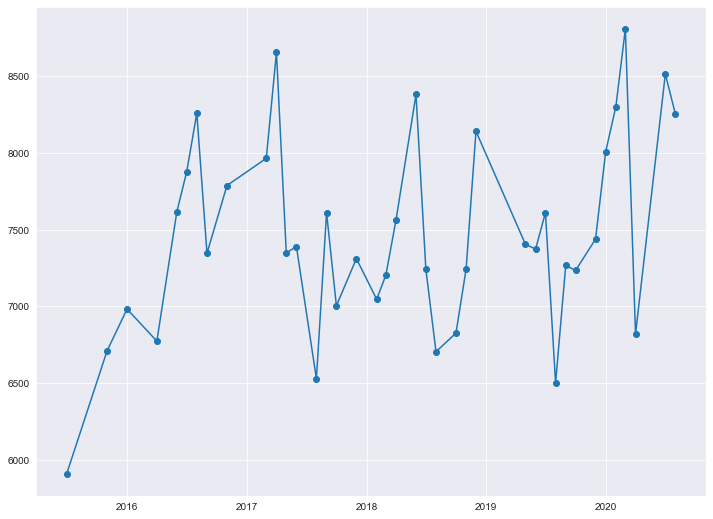

In [107]:
df_b=hdb_ts[(hdb_ts['town']=='CLEMENTI') & (hdb_ts['age']<=10)]
ts_b = df_b.groupby(['year','month'])['price_per'].median().fillna(method='bfill').reset_index(name='monthly_price')
ts_b['date'] = pd.to_datetime(ts_b[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_b['date'], ts_b['monthly_price'],linestyle = 'solid')
plt.show()  

In [109]:

from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_b['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_b.loc[38,'monthly_price'])/ts_b.loc[38,'monthly_price']
pct_gain

-0.0642055419985669

#### HOUGANG-5 room

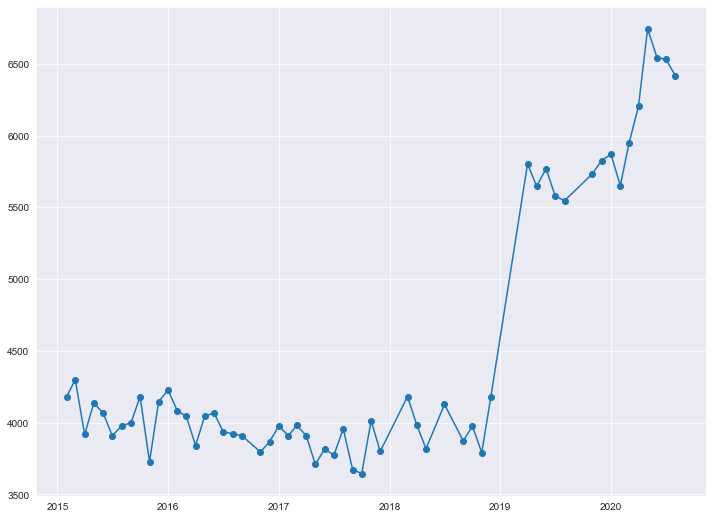

In [17]:
df_k=hdb_ts[(hdb_ts['town']=='HOUGANG')& (hdb_ts['age']<=10)]
ts_k = df_k.groupby(['year','month'])['price_per'].median().dropna().reset_index(name='monthly_price')
ts_k['date'] = pd.to_datetime(ts_k[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_k['date'], ts_k['monthly_price'],linestyle = 'solid')
plt.show()

In [18]:

from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_k['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_k.loc[56,'monthly_price'])/ts_k.loc[56,'monthly_price']
pct_gain

0.3808231956063516

In [19]:
ts_k

,year,month,monthly_price,date
0,2015,2,4181.818182,2015-02-01
1,2015,3,4300.000000,2015-03-01
2,2015,4,3917.672727,2015-04-01
3,2015,5,4136.363636,2015-05-01
4,2015,6,4068.181818,2015-06-01
5,2015,7,3909.090909,2015-07-01
6,2015,8,3977.272727,2015-08-01
7,2015,9,4000.000000,2015-09-01
8,2015,10,4181.818182,2015-10-01
9,2015,11,3727.272727,2015-11-01


#### CLEMENTI - 4 room

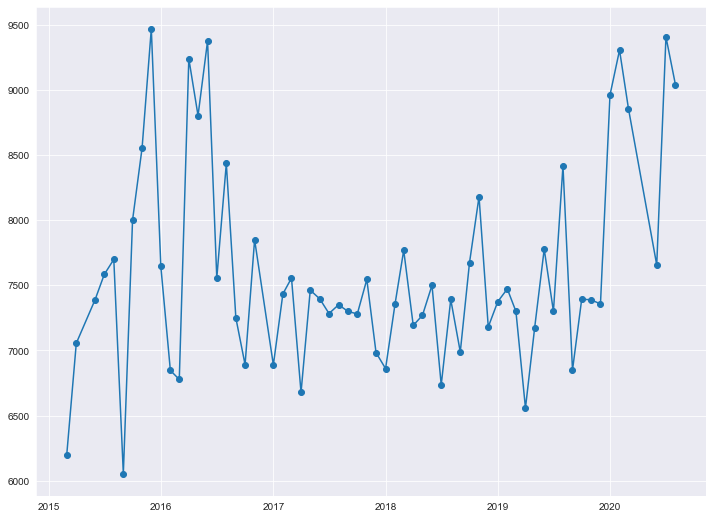

In [25]:
df_q=hdb_ts2[(hdb_ts2['town']=='CLEMENTI')& (hdb_ts2['age']<=10)]
ts_q = df_q.groupby(['year','month'])['price_per'].median().dropna().reset_index(name='monthly_price')
ts_q['date'] = pd.to_datetime(ts_q[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_q['date'], ts_q['monthly_price'],linestyle = 'solid')
plt.show()

In [26]:

from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_q['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_q.loc[61,'monthly_price'])/ts_q.loc[61,'monthly_price']
pct_gain


0.22381350721259582

In [27]:
ts_q

,year,month,monthly_price,date
0,2015,3,6201.550388,2015-03-01
1,2015,4,7055.555556,2015-04-01
2,2015,6,7388.888889,2015-06-01
3,2015,7,7583.333333,2015-07-01
4,2015,8,7698.755556,2015-08-01
...,...,...,...,...
57,2020,2,9304.878049,2020-02-01
58,2020,3,8856.250000,2020-03-01
59,2020,6,7656.250000,2020-06-01
60,2020,7,9406.250000,2020-07-01


#### HOUGANG-4 room

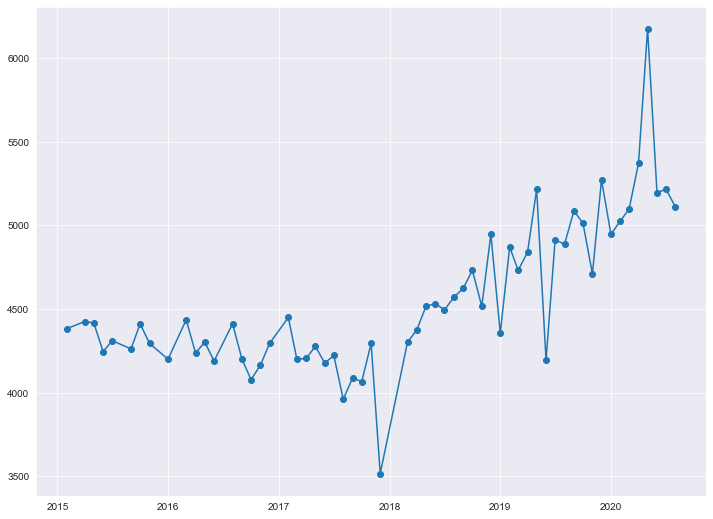

In [20]:
df_c=hdb_ts2[(hdb_ts2['town']=='HOUGANG')& (hdb_ts2['age']<=10)]
ts_c = df_c.groupby(['year','month'])['price_per'].median().dropna().reset_index(name='monthly_price')
ts_c['date'] = pd.to_datetime(ts_c[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_c['date'], ts_c['monthly_price'],linestyle = 'solid')
plt.show()

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_c['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_c.loc[58,'monthly_price'])/ts_c.loc[58,'monthly_price']
pct_gain

0.2878842370196357

In [22]:
ts_c

,year,month,monthly_price,date
0,2015,2,4382.352941,2015-02-01
1,2015,4,4424.836601,2015-04-01
2,2015,5,4416.993464,2015-05-01
3,2015,6,4245.424837,2015-06-01
4,2015,7,4311.111111,2015-07-01
5,2015,9,4261.111111,2015-09-01
6,2015,10,4411.764706,2015-10-01
7,2015,11,4294.117647,2015-11-01
8,2016,1,4200.000000,2016-01-01
9,2016,3,4435.294118,2016-03-01


#### CENTRAL AREA-5 room

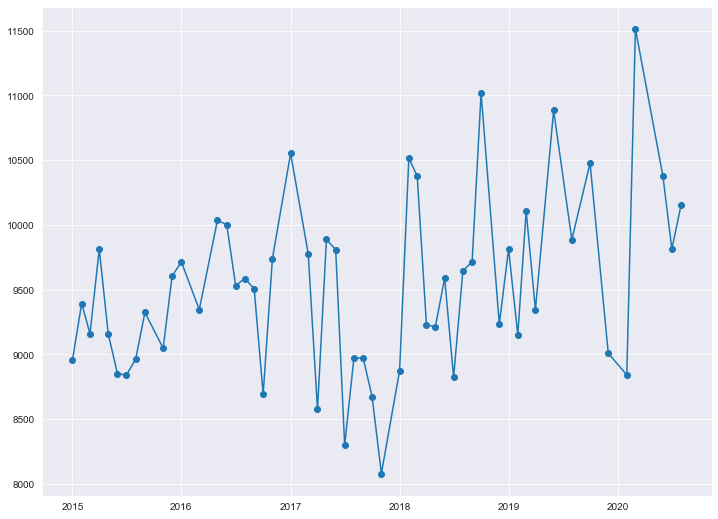

In [152]:
df_c=hdb_ts[(hdb_ts['town']=='CENTRAL AREA')& (hdb_ts['age']<=10)]
ts_c = df_c.groupby(['year','month'])['price_per'].median().dropna().reset_index(name='monthly_price')
ts_c['date'] = pd.to_datetime(ts_c[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_c['date'], ts_c['monthly_price'],linestyle = 'solid')
plt.show()

In [154]:
from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_c['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_c.loc[53,'monthly_price'])/ts_c.loc[53,'monthly_price']
pct_gain

-0.007189021258295864

#### CENTRAL AREA-4 room

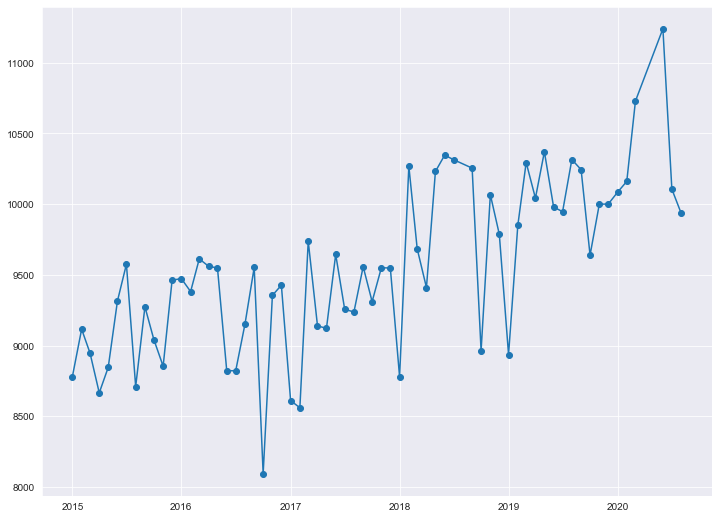

In [23]:
df_c=hdb_ts2[(hdb_ts2['town']=='CENTRAL AREA')& (hdb_ts2['age']<=10)]
ts_c = df_c.groupby(['year','month'])['price_per'].median().dropna().reset_index(name='monthly_price')
ts_c['date'] = pd.to_datetime(ts_c[['year', 'month']].assign(DAY=1))
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( ts_c['date'], ts_c['monthly_price'],linestyle = 'solid')
plt.show()

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing
HW_model = ExponentialSmoothing(ts_c['monthly_price'],trend='add', seasonal='add',seasonal_periods = 12).fit()
pred  = list(HW_model.forecast(36))
pct_gain=(pred[-1]-ts_c.loc[53,'monthly_price'])/ts_c.loc[53,'monthly_price']
pct_gain

0.11611657042767003